# Open-source LLM's as Agents with `HuggingFaceChatWrapper`


Open source LLMs are becoming viable general purpose agents. The goal of this notebook is to demonstrate how to make use of open-source LLMs as chat models using [Hugging Face Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) with [LangChain's `HuggingFaceChatWrapper`]() to enable their usage and experimentation with agent-based workflows.

In particular, we will:
1. Utilize the [HuggingFaceEndpoint](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_endpoint.py) (or [HuggingFaceTextGenInference](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_text_gen_inference.py) or [HuggingFaceHub](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_hub.py)) integration to call a [HF Inference Endpoint](https://huggingface.co/inference-endpoints) that's serving an LLM via [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/index)
2. Utilize the `HuggingFaceChatWrapper` class that interfaces between LangChain's [Chat Messages](https://python.langchain.com/docs/modules/model_io/chat/#messages) and the hosted LLM by leveraging [Hugging Face's Chat Templates](https://huggingface.co/docs/transformers/chat_templating) to power a `ChatAgent` pipeline.
4. Demonstrate how to use an open-source LLM in a zero-shot ReAct Agent workflow, along with an open-source [Prometheus](https://huggingface.co/papers/2310.08491) model to perform "LLM as a Judge"-style evaluations on that Agent's ouputs.
5. Understand how several different open-source LLM's perform as general purpose agents by running an asynchronous evaluation pipeline using Prometheus as the judge. 



> Note: To run this notebook, you'll need to have:
> - an LLM deployed via a Hugging Face Inference Endpoint (the LLM must have a `chat_template` defined in its `tokenizer_config.json`)
> - A Hugging Face Token with access to the deployed endpoint saved as an environment variable: `HUGGINGFACEHUB_API_TOKEN`
> - A SerpAPI key saved as an environment variable: `SERPAPI_API_KEY`


## Setup

In [1]:
!pip install -q transformers langchain text-generation python-dotenv jinja2 langchainhub numexpr datasets tqdm openai sentencepiece protobuf matplotlib wikipedia


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ruff: noqa: E402

from dotenv import load_dotenv

load_dotenv(override=True)

True

## 1. Instantiate an LLM

You'll need to have a running Inference Endpoint available.

#### `HuggingFaceHub`

In [4]:
from langchain.llms.huggingface_hub import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id='HuggingFaceH4/zephyr-7b-beta',
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

/home/ubuntu/langchain/libs/langchain/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


#### `HuggingFaceEndpoint`

In [5]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = "https://mwgkynxou5oy7i3j.us-east-1.aws.endpoints.huggingface.cloud"  # openhermes
# endpoint_url = 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud'  # mixtral
llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 488,
        "top_k": 50,
        "repetition_penalty": 1.03,
    },
)

In [6]:
llm.invoke('ok')

", so I'm new here as well, but I thought I'd share with you all the experience i have had with my PSP.\n\nTo begin with, don't worry. The PSP is a great device and is really fun to do stuff with. But it's not going to be perfect, well anything is not going to be perfect these days. But the great thing about the PSP as a unit to the Sony company and to the geeks out there is that it allows the end user (the one who buys it) to mod it and make it do whatever he wants. So if your going to get a PSP, i recommend you at least search on forums and or websites that offer tips and tricks for modding the PSP to your hearts delight.\n\nWith that being said, the PSP in my opinion is still great even if you mod it or not, I have a friend who just plays the games on it, and he loves it too!\nSo you don't gotta do this or that with it, just use it and love it however you wanna. :)\n\nIf you need any more help as a newbie here, feel free to ask away, I'll try my best to help you out or steer you tow

## 2. Create a wrapper for `BaseChatModel` to apply chat templates

In [7]:
from langchain.schema import (
    HumanMessage,
    SystemMessage,
)

from chat_wrapper import HuggingFaceChatWrapper

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Instantiate the model and some messages to pass.

In [8]:
messages = [
    HumanMessage(content="You're a helpful assistant. What happens when an unstoppable force meets an immovable object?"),
]

chat_model = HuggingFaceChatWrapper(llm=llm)

WARNING! endpoint_url is not default parameter.
                    endpoint_url was transferred to model_kwargs.
                    Please confirm that endpoint_url is what you intended.
WARNING! task is not default parameter.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
WARNING! huggingfacehub_api_token is not default parameter.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Inspect which model and corresponding chat template is being used.

In [9]:
chat_model.model_id

'teknium/OpenHermes-2.5-Mistral-7B'

Call the model.

In [10]:
res = chat_model.invoke(messages)
print(res.content)

When an unstoppable force meets an immovable object, it is said that "nothing can be determined" because the two concepts seem to contradict each other. The concept of an unstoppable force is something that cannot be stopped or resisted, while an immovable object is something that cannot be moved or displaced. It would be impossible for both these concepts to occur simultaneously, as they each represent absolute states that cannot coexist. However, this phrase is often used metaphorically to describe situations where two opposing forces are evenly matched and neither can overcome the other.


## Tests

Here we'll test out our model as a zero-shot ReAct Agent. The example below is taken from [here](https://python.langchain.com/docs/modules/agents/agent_types/react#using-chat-models).

In [11]:
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents import AgentExecutor
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from prompts import SYSTEM_PROMPT, HUMAN_PROMPT
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

Configure the agent with a `react-json` style prompt and access to a search engine and calculator.

### Define tools

In [12]:
from langchain.tools import WikipediaQueryRun, tool
from langchain.utilities import WikipediaAPIWrapper
from langchain.agents import load_tools
from langchain.tools.render import render_text_description_and_args


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [13]:
tools = load_tools(["serpapi", "llm-math"], llm=llm)

@tool
def get_word_count(sentence: str) -> int:
    """Returns the number of words in a sentence."""
    return len(sentence.split())

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

@tool
def search_wikipedia(query: str) -> str:
    """Searches Wikipedia for a query. This will not be relevant for the latest information, but it can be useful for historical knowledge."""
    return wikipedia.run(query)


TOOLS = tools + [search_wikipedia]

In [14]:
if 'mistral' in chat_model.model_id:
    prompt = ChatPromptTemplate.from_messages(
        [
            HumanMessagePromptTemplate.from_template(SYSTEM_PROMPT+'\nSo, here is my question:'+HUMAN_PROMPT),
        ]
    )
else:
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT),
            HumanMessagePromptTemplate.from_template(HUMAN_PROMPT),
        ]
    )
prompt = prompt.partial(
    tool_description=render_text_description_and_args(TOOLS),
    tool_names=", ".join([t.name for t in TOOLS]),
)

# define the agent
chat_model_with_stop = chat_model.bind(stop=["\nObservation"])
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | chat_model_with_stop
    | ReActJsonSingleInputOutputParser()
)

# instantiate AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=TOOLS,
    verbose=True,
    return_intermediate_steps=True,
    handle_parsing_errors=True,
    max_iterations=5,
)

In [15]:
example = {
    "input": "What is the age of Leonardo DiCaprio's current girlfriend, raised to the power 0.43?"
}

out = agent_executor.invoke(example)



> Entering new AgentExecutor chain...
Question: What is the age of Leonardo DiCaprio's current girlfriend, raised to the power 0.43?

Thought: I need to find out the current girlfriend of Leonardo DiCaprio.
Action:
```
{
  "action": "search",
  "action_input": "leonardo dicaprio current girlfriend"
}
```search is not a valid tool, try one of [Search, Calculator, search_wikipedia].I apologize for the confusion. The search tool is not available, so I will need to use the search_wikipedia tool instead.

Thought: Now I need to find the current girlfriend of Leonardo DiCaprio using the search_wikipedia tool.
Action:
```
{
  "action": "search_wikipedia",
  "action_input": "leonardo dicaprio current girlfriend"
}
```Page: River Phoenix
Summary: River Jude Phoenix (né Bottom; August 23, 1970 – October 31, 1993) was an American actor and musician. Phoenix was known as a teen actor before taking on leading roles in critically acclaimed films. He received numerous accolades including Volpi Cup 

## Evaluate the agent's ouput by criteria: correctness

In [17]:
from langchain.chat_models import ChatOpenAI

eval_chat_model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0)

In [18]:
from prompts import EVALUATION_PROMPT

evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

correctness_criteria = {
    "criteria_description": "Is the response correct, accurate, and factual based on the reference answer?",
    "score1_description": "The response is completely incorrect, inaccurate, and/or not factual.",
    "score2_description": "The response is mostly incorrect, inaccurate, and/or not factual.",
    "score3_description": "The response is somewhat correct, accurate, and/or factual.",
    "score4_description": "The response is mostly correct, accurate, and factual.",
    "score5_description": "The response is completely correct, accurate, and factual.",
}

correctness_prompt_template = evaluation_prompt_template.partial(
    criteria_description=correctness_criteria["criteria_description"],
    score1_description=correctness_criteria["score1_description"],
    score2_description=correctness_criteria["score2_description"],
    score3_description=correctness_criteria["score3_description"],
    score4_description=correctness_criteria["score4_description"],
    score5_description=correctness_criteria["score5_description"],
)

In [19]:
eval_prompt = correctness_prompt_template.format_messages(
    instruction=example["input"],
    response=out["output"],
    reference_answer="Vittoria Ceretti who is 25 years old. When age of 25 is raised to power of 0.43, we get 3.99",
)

In [20]:
print(eval_prompt[1].content)

###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "Feedback: {write a feedback for criteria} [RESULT] {an integer number between 1 and 5}"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
What is the age of Leonardo DiCaprio's current girlfriend, raised to the power 0.43?

###Response to evaluate:
Agent stopped due to iteration limit or time limit.

###Reference Answer (Score 5):
Vittoria Ceretti who is 25 years old. When age of 25 is raised 

In [21]:
eval_out = eval_chat_model.invoke(eval_prompt)
print(eval_out)

content="Feedback: The response does not provide any information regarding the age of Leonardo DiCaprio's current girlfriend or the result of raising that age to the power of 0.43. It fails to address the question and instead indicates a technical issue that prevented the completion of the task. According to the score rubric, the response must be evaluated as completely incorrect, inaccurate, and not factual, as it does not contain any factual information related to the question. [RESULT] 1"


# Evaluation Experiment 

- Find a group of test questions that use a certain set of tools to solve (HotpotQA)
- Run several different models as agent to solve the test questions (OS and proprietary)
- Use a LLM as a judge
- Use OS models as a judge
- Report correlations

## Create evaluation dataset

In [22]:
from datasets import load_dataset, concatenate_datasets

hotpotqa_dataset = load_dataset("hotpot_qa", "distractor")

# let's sample a few examples from each level (of difficulty) and type (comparion or bridge)
hotpotqa_dataset.set_format("pandas")
dataset_df = hotpotqa_dataset["train"][:]
sample_indicies = (
    dataset_df.groupby(["level", "type"]).sample(2, random_state=10).index.values
)
hotpotqa_dataset.reset_format()
hotpotqa_dataset = hotpotqa_dataset["train"].select(sample_indicies)
task_column = [f"HotpotQA-{level}" for level in hotpotqa_dataset["level"]]
hotpotqa_dataset = hotpotqa_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])

In [23]:
import numpy as np
np.random.seed(42)
math_dataset = load_dataset("gsm8k", "main")['train']
math_dataset = math_dataset.select(np.random.randint(0, len(math_dataset), 10))
task_column = ["Math"] * len(math_dataset)
math_dataset = math_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])

In [24]:
gaia_dataset = load_dataset("gaia-benchmark/GAIA", "2023_level1")['validation']
gaia_dataset.set_format('pandas')
gaia_dataset_df = gaia_dataset[:]
gaia_dataset_df['number_of_steps'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: int(row['Number of steps']))
gaia_dataset_df['tools_used'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: row['Tools'])
gaia_dataset_df = gaia_dataset_df.loc[~gaia_dataset_df['tools_used'].str.lower().str.contains('pdf|excel|image|video|parsing|audio|word|file|speech|viewer|markdown|python|editor')]

/home/ubuntu/langchain/libs/langchain/venv/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [25]:
selected_indicies = [1, 18, 23, 29, 39, 42, 47, 49, 50, 52]
gaia_dataset = gaia_dataset.rename_columns({'Question': 'question', 'Final answer': 'answer'}).select_columns(['question', 'answer'])
gaia_dataset.reset_format()
gaia_dataset = gaia_dataset.select(selected_indicies)

task_column = ['GAIA'] * len(gaia_dataset)
gaia_dataset = gaia_dataset.add_column('task', task_column)

In [27]:
import pandas as pd

dataset = concatenate_datasets([math_dataset, hotpotqa_dataset, gaia_dataset])
pd.DataFrame(dataset).head()

,question,answer,task
0,Bob is tilling a plot of his garden. The plot ...,If Bob goes along the side that's 120 feet lon...,Math
1,Earl has $90; Fred has $48; Greg has $36. Earl...,Earl will have $90 - $28 = $<<90-28=62>>62 aft...,Math
2,A milk teas shop was able to sell a total of 5...,A milk tea shop sold 50 x 2/5 = <<50*2/5=20>>2...,Math
3,A party venue has 4 tables that seat 6 people ...,Four 6-seater tables can accommodate 4 x 6 = <...,Math
4,Paul is collecting license plates from differe...,The proportion of plates that he has out of to...,Math
5,The running time of Beast of War: Armoured Com...,One hour contains 60 minutes so 2 hours contai...,Math
6,"A hardware store sold 10 graphics cards, 14 ha...",It earned 10*600 = <<10*600=6000>>6000 dollars...,Math
7,Darry is a roofer and has to climb ladders mul...,Climbing the full ladder means Darry has climb...,Math
8,Hunter needs to make a square patch of land wh...,If the rectangular patch of land measures 400 ...,Math
9,"At Snowflake Plastics, each employee gets 10 s...","First, we add the two types of days together t...",Math


# Run evaluation

In [28]:
from evaluation import run_full_eval, build_hf_agent, build_openai_agent

agent_endpoints = [
    # "https://j02macig8fbovqhr.us-east-1.aws.endpoints.huggingface.cloud",  # zephyr-7b-beta
    # "https://i45e7q2do4r8mw5k.us-east-1.aws.endpoints.huggingface.cloud",  # notus-7b
    'https://mwgkynxou5oy7i3j.us-east-1.aws.endpoints.huggingface.cloud',  # open-hermes-2.5-7b
    # 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud', # mixtral-7x8b
    # 'https://h0qwp3dx2iixajoh.us-east-1.aws.endpoints.huggingface.cloud', # llama2-7b
]
agent_executors = [build_hf_agent(endpoint, TOOLS) for endpoint in agent_endpoints]

agents = {
    agent_executor.dict()["agent"]["runnable"]["middle"][-1]["bound"]["_type"].replace('/',':'): agent_executor
    for agent_executor in agent_executors
}

# uncomment below to test GPT4 as an agent
agents['GPT4'] = build_openai_agent(TOOLS, model_id='gpt-4-1106-preview')

# run eval
await run_full_eval(
    dataset=dataset,
    agents=agents,
    evaluator=eval_chat_model,
    eval_prompt_template=correctness_prompt_template,
)

WARNING! endpoint_url is not default parameter.
                    endpoint_url was transferred to model_kwargs.
                    Please confirm that endpoint_url is what you intended.
WARNING! task is not default parameter.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
WARNING! huggingfacehub_api_token is not default parameter.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 32/32 [00:00<00:00, 20831.56it/s]


,agent_model_id,question,gt_answer,prediction,eval_score,eval_feedback,parsing_error,iteration_limit_exceeded,agent_error,start_time,end_time,task
0,teknium/openhermes-2.5-mistral-7b-style,Bob is tilling a plot of his garden. The plot ...,If Bob goes along the side that's 120 feet lon...,It will take Bob 1100 seconds or approximately...,1,The response provided is incorrect when compar...,False,False,None,2023-12-13 12:24:04,2023-12-13 12:25:08,Math
1,teknium/openhermes-2.5-mistral-7b-style,Earl has $90; Fred has $48; Greg has $36. Earl...,Earl will have $90 - $28 = $<<90-28=62>>62 aft...,Agent stopped due to iteration limit or time l...,1,Feedback: The response provided does not conta...,True,True,None,2023-12-13 12:25:08,2023-12-13 12:25:57,Math
2,teknium/openhermes-2.5-mistral-7b-style,A milk teas shop was able to sell a total of 5...,A milk tea shop sold 50 x 2/5 = <<50*2/5=20>>2...,83.33333333333334\nThought: I now know the fin...,1,Feedback: The response provided is completely ...,False,False,None,2023-12-13 12:25:57,2023-12-13 12:26:41,Math
3,teknium/openhermes-2.5-mistral-7b-style,A party venue has 4 tables that seat 6 people ...,Four 6-seater tables can accommodate 4 x 6 = <...,168\n<|im_end|>,5,"The response provided is completely correct, a...",False,False,None,2023-12-13 12:26:41,2023-12-13 12:27:04,Math
4,teknium/openhermes-2.5-mistral-7b-style,Paul is collecting license plates from differe...,The proportion of plates that he has out of to...,None,None,None,False,False,ValidationError(model='search_wikipediaSchemaS...,2023-12-13 12:41:28,2023-12-13 12:41:39,Math
5,teknium/openhermes-2.5-mistral-7b-style,The running time of Beast of War: Armoured Com...,One hour contains 60 minutes so 2 hours contai...,100\nThought: I now know the final answer.,5,Feedback: The response provided is completely ...,False,False,None,2023-12-13 12:41:39,2023-12-13 12:42:09,Math
6,teknium/openhermes-2.5-mistral-7b-style,"A hardware store sold 10 graphics cards, 14 ha...",It earned 10*600 = <<10*600=6000>>6000 dollars...,"The hardware store earned $9,200 this week fro...",3,The response provided states that the hardware...,False,False,None,2023-12-13 12:42:09,2023-12-13 12:42:43,Math
7,teknium/openhermes-2.5-mistral-7b-style,Darry is a roofer and has to climb ladders mul...,Climbing the full ladder means Darry has climb...,152\nThe answer is 152.,5,Feedback: The response provided is completely ...,False,False,None,2023-12-13 12:42:43,2023-12-13 12:43:05,Math
8,teknium/openhermes-2.5-mistral-7b-style,Hunter needs to make a square patch of land wh...,If the rectangular patch of land measures 400 ...,None,None,None,False,False,"ValueError('LLMMathChain._evaluate(""\nnp.sqrt(...",2023-12-13 12:43:05,2023-12-13 12:43:35,Math
9,teknium/openhermes-2.5-mistral-7b-style,"At Snowflake Plastics, each employee gets 10 s...","First, we add the two types of days together t...",Mark has 80.0 hours' worth of days left.,5,Feedback: The response provided is completely ...,False,False,None,2023-12-13 12:43:35,2023-12-13 12:44:15,Math


### Compare results

In [29]:
import glob

results = []
for file in glob.glob("output/*.json"):
    print(file)
    with open(file) as f:
        results.append(pd.read_json(f))

result_df = pd.concat(results)

output/GPT4.json
output/teknium:openhermes-2.5-mistral-7b-style.json


In [32]:
result_df = result_df.loc[result_df['eval_score'].apply(lambda x: x is not None and x != 'nan' and x!="inf" and x!="No Score")]

In [33]:
result_df.eval_score = result_df.eval_score.astype(int)

result_df.groupby("agent_model_id").agg(
    {"eval_score": "mean", "parsing_error": "sum", "iteration_limit_exceeded": "sum"}
)

,eval_score,parsing_error,iteration_limit_exceeded
agent_model_id,,,
GPT4,3.812500,0,3
teknium/openhermes-2.5-mistral-7b-style,2.304348,10,12


                                        eval_score                \
task                                          GAIA HotpotQA-easy   
agent_model_id                                                     
GPT4                                           2.4      4.000000   
teknium/openhermes-2.5-mistral-7b-style        1.0      2.333333   

                                                                             
task                                    HotpotQA-hard HotpotQA-medium  Math  
agent_model_id                                                               
GPT4                                              4.0             5.0  4.60  
teknium/openhermes-2.5-mistral-7b-style           3.0             3.0  3.25  


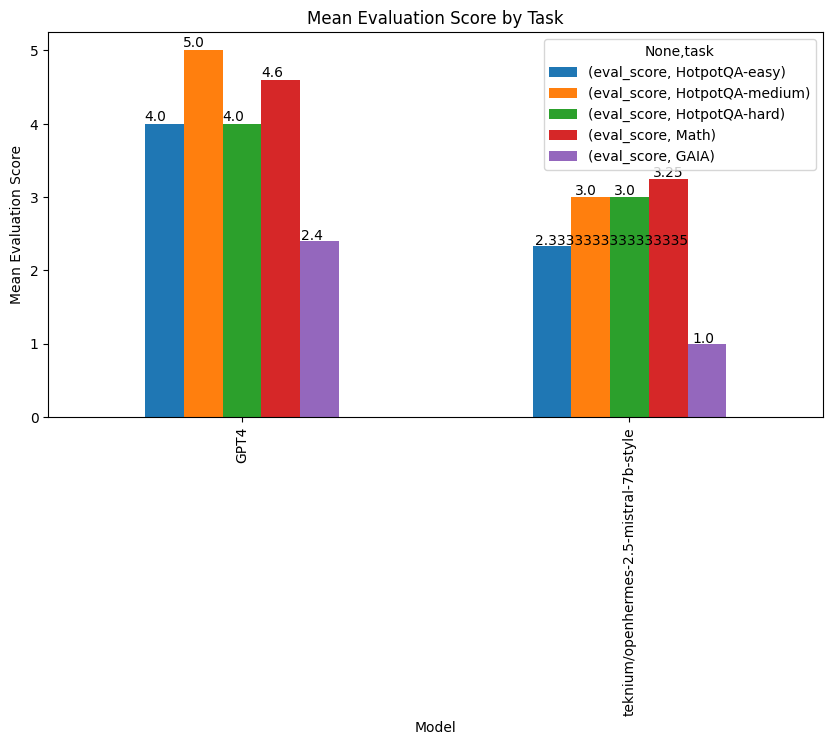

In [34]:
agg_df = (
    result_df.groupby(["agent_model_id", "task"])
    .agg({"eval_score": "mean"})
    .unstack("task")
)
print(agg_df)

ax = agg_df[
    [("eval_score", "HotpotQA-easy"), ("eval_score", "HotpotQA-medium"), ("eval_score", "HotpotQA-hard"), ("eval_score", "Math"), ("eval_score", "GAIA")]
].plot.bar(
    figsize=(10, 5),
    title="Mean Evaluation Score by Task",
    xlabel="Model",
    ylabel="Mean Evaluation Score",
)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

#### visualizations to make
- avg model score by question difficulty
- count of parsing errors and iteration limit errors

## To-do:
- Generalize evaluation code
- Make evals fully async
- Select 3-5 models to evaluate on
- Run eval
- Write blog post
- Get LangChain PR merged

## Notes

- One of the main challenges with open LLMs is ensuring they adhere to the proper markdown JSON output!
- Another is when they serve as the evaluator, they struggle to handle the default "labeled_criteria" prompt and end up hallucinating. Needs to be modified / simplified.
- I also found that GPT4 actually did pretty poor at judging correctness given the default LangChain prompt!